In [1]:
from importlib import reload
from copy import deepcopy
import os
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

if not os.path.isdir("./cache"): os.mkdir("cache")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
from utils_lib import utils

device: cuda
Prepare 12Net data
Finished


## Net 12

In [2]:
Net12 = nn.Sequential(
    # 3 X 12 X 12
    nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
    # 16 X 12 X 12
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 16 X 6 X 6
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 6 *6, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)
# utils.train_12Net(Net12, Epochs = 10, save = False)

### Simple Detector

Modify the 12 Net into FCN:

In [2]:
Net12 = torch.load("cache/models.12Net.best_model")

In [3]:
Net12_layers = list(Net12._modules.values())
#
conv_layer1 = nn.Conv2d(16, 16, kernel_size = 6, stride = 1)
conv_layer1.weight.data = Net12_layers[-3].weight.data.view((16, 16, 6, 6)).detach().clone()
conv_layer1.bias.data = Net12_layers[-3].bias.data.detach().clone()
#
conv_layer2 = nn.Conv2d(16, 2, kernel_size = 1, stride = 1)
conv_layer2.weight.data = Net12_layers[-1].weight.data.view((2, 16, 1, 1)).detach().clone()
conv_layer2.bias.data = Net12_layers[-1].bias.data.detach().clone()

Net12Detector_layers = [deepcopy(l) for l in Net12_layers[:-4]] + [conv_layer1, nn.ReLU(), conv_layer2, nn.Softmax(dim = 1)]
Net12_FCN = nn.Sequential(*Net12Detector_layers)

In [4]:
Net12_FCN = Net12_FCN.to(device)
def detector_model(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.1, 0.3, 0.5, 0.7,1]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    outs = []
    for scale in scales:
        outs.append(utils.scale_model_nms_pipeline(x, scale, Net12_FCN, iou_threshold = iou_threshold).cpu())
    return torch.cat(outs, 0)


In [19]:
reload(utils)
scales = [0.05, 0.08, 0.13, 0.2]
ts = (0.1, 0.2, 0.4, 0.6, 0.8, 0.9)
for t in ts:
    name =  f"scales_with_resizes/{'_'.join(map(str, scales))}/{t}"
    utils.gen_fddb_out(lambda x: detector_model(path = x, iou_threshold = t, scales = scales), ellipse = False, name = name)
    cmd = f"./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/{'_'.join(map(str, scales))}/{t}/"
    print(f">>> {cmd}", end = "")
    r = os.system(cmd) 
    print(f", result: {r}")

>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/0.05_0.08_0.13_0.2/0.1/, result: 0
>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/0.05_0.08_0.13_0.2/0.2/, result: 0
>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/0.05_0.08_0.13_0.2/0.4/, result: 0
>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/0.05_0.08_0.13_0.2/0.6/, result: 0
>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/0.05_0.08_0.13_0.2/0.8/, result: 0
>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/0.05_0.08_0.13_0.2/0.9/, result: 0


## 24 Net

In [21]:
utils.mData24.init(detector_model)

Prepare 24Net data...
Finished


In [ ]:
Net24 = nn.Sequential(
    # 3 X 24 X 24
    nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
    # 64 X 24 X 24
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 64 X 12 X 12
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
utils.train_24Net(Net24, Epochs = 1500, save = True)

>>> Epoch 0, train: loss 0.2966 acc 0.9173, test: loss 0.1375 acc 0.9579, 


## Better Detector

In [ ]:
Net24 = torch.load("cache/models.23Net.best_model")

In [ ]:
Net24= Net24.to(device)
def detector_model2(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.1, 0.3, 0.5, 0.7,1]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    out = utils.scale_model_nms_pipeline(x, scales, Net12_FCN, iou_threshold = iou_threshold).cpu()
    # use 24Net to reduce FP
    out_resized = utils.get_resized_crops(x, out)
    

In [ ]:
device = torch.device("cuda:5")
t = torch.cuda.get_device_properties(device).total_memory
c = torch.cuda.memory_reserved(device)
a = torch.cuda.memory_allocated(device)
f = c-a  # free inside cache


In [ ]:
[i / (2 ** 20) for i in (t, c, a, f)]

In [ ]:
reload(utils)
x = torch.rand([1, 3, 12, 12], dtype = torch.float32)
out1 = Net12.cpu()(x)
out1 = F.softmax(out1, dim = 1).flatten()
out2 = Net12_FCN.cpu()(x).flatten()
out1 - out2 < 1e-10

In [ ]:
o =detector_model(path = path)

In [18]:
a = o[o[:,-1] > 0.9, :]

In [19]:
a

tensor([], size=(0, 5))

In [1]:
reload(utils)

NameError: name 'reload' is not defined

torch.Size([3, 5])
0
1
2


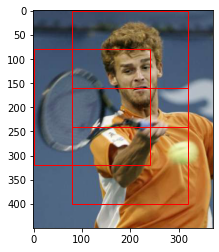

In [10]:
path = "./data/EX2_data/fddb/images/2002/09/01/big/img_16189.jpg"
r = detector_model(path = path, iou_threshold = 0.3, scales = [0.05])
print(r.shape)
# r = list(sorted(r, key=lambda x: -x[-1]))
x = Image.open(path)
utils.plot_with_rec(x, r,scale =1)

tensor([[ 80.0000,   0.0000, 320.0000, 240.0000,   0.6162],
        [  0.0000,  80.0000, 240.0000, 320.0000,   0.6152],
        [ 80.0000, 160.0000, 320.0000, 400.0000,   0.6141]])


In [21]:
r[-1]

tensor([300., 436., 312., 448.,   1.])

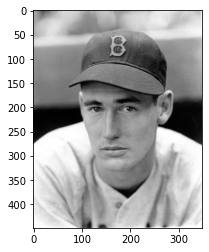

In [28]:
reload(utils)
x = Image.open("./data/EX2_data/fddb/images/2002/07/22/big/img_725.jpg")
# plt.imshow(x)
x = TF.to_tensor(x)
x = torch.cat([x]*3, dim = 0)
utils.plt_tensor(x)

In [745]:
scale = 0.1
r = scale_fcn_boxes(x, scale, Net12_FCN, 0.2)
r.shape

torch.Size([15, 5])

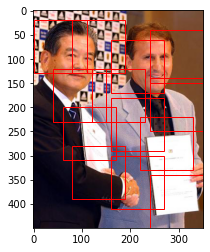

In [746]:
utils.plot_with_rec(x, r,scale =scale, limit = 0.9)

In [725]:
reload(utils)
x = torch.rand((2, 3,450, 377))
out = Net12_FCN(x)

In [256]:
out.shape

torch.Size([2, 2, 220, 184])

In [262]:
utils.nms(out, 0.4)[1, 1, :]

tensor([154.0000,   0.0000, 165.0000,  11.0000,   0.5950])

### FDDB

In [345]:
x._size

(275, 450)

In [346]:
x = TF.to_tensor(x)
x.shape
# x = TF.resize(x, size = (100, 100))

torch.Size([3, 450, 275])

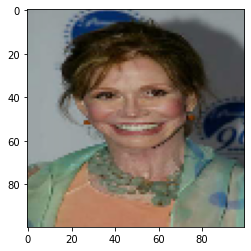

In [330]:
utils.plt_tensor(x)

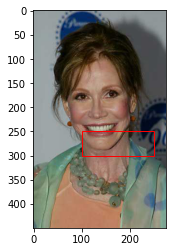

In [378]:

# Display the image
plt.imshow(x)
# Add the patch to the Axes
plt.gca().add_patch(Rectangle((100, 250),150, 50,linewidth=1,edgecolor='r',facecolor='none'))


In [4]:
len(utils.mData.aflw[12])

24385